# MNIST Tutorial : classify digits using Tensorflow

### You can refer to the original tutorial to get detailed explanations :
* [if you never heard of MNIST, softmax, backpropagation](https://www.tensorflow.org/get_started/mnist/beginners)

* [if you are a MNIST expert!](https://www.tensorflow.org/get_started/mnist/pros)

This tutorial is an introduction to tensorflow. At the end, given an image of a digit, you will be able to predict which digit it is. You will also understand the principal steps to train a neural network model.

To install tensorflow in your machine, follow [these steps](https://www.tensorflow.org/install/)

In [1]:
import tensorflow as tf
import numpy as np  # library to process arrays

___
### Import data
MNIST is a simple computer vision dataset. It consists of images of handwritten digits.
It will be downloaded in your current directory (or loaded from the specified directory if you already downloaded it)

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


___
### MNIST Dataset structure
* training set (55 000) : `mnist.train`
* testing set (10 000) : `mnist.testing`
* validation set (1 000) : `mnist.validation`

Each set contains `images` and `labels`. ( i.e `mnist.train.images`)

Labels are `one-hot` vectors. A one-hot vector is a vector which is 0 in most dimensions, and 1 in a single dimension. In our case, the nth digit will be represented as a vector which is 1 in the nth dimension.

The images have dimensions `28x28`, and will be processed as flatten vectors of dimension 784 (28x28).

#### Example of one digit image

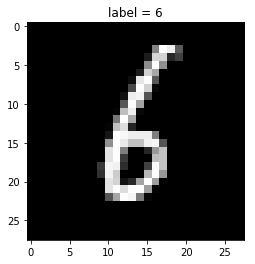

In [3]:
# Import the library to show the image
import matplotlib.pyplot as plt
%matplotlib inline

# Rehape 784 vector to 28x28 image and show in grayscale
index = 98
plt.imshow(np.reshape(mnist.train.images[index], [28,28]), cmap='gray')
plt.title('label = {}'.format(np.argmax(mnist.train.labels[index])))

_______
### Some key TF concepts 

#### Tensor
The central unit of data in TensorFlow is the tensor. A tensor consists of a set of primitive values shaped into an array of any number of dimensions. A tensor's rank is its number of dimensions.

#### [Tensorflow's computational graph](https://www.tensorflow.org/get_started/get_started#the_computational_graph)
A computational graph is a series of TensorFlow operations arranged into a graph of nodes. Each node takes zero or more tensors as inputs and produces a tensor as an output.
There are two separate steps in a Tensorflow programm : 
* Building the graph
* Running the graph

To evaluate the nodes, the computational graph must be run within a session. A session encapsulates the control and state of the TensorFlow runtime.
______

### Simple model (see perceptron slide in the course)
We will build a simple neuron that take an input `x`, multiplies it by some weight `W` and adds a bias `b`.

In [4]:
# Create the neuron
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
y = tf.matmul(x, W) + b

`x` isn't a specific value. It's a `placeholder`, a value that we'll input when we ask TensorFlow to run a computation. We want to be able to input any number of MNIST images, each flattened into a 784-dimensional vector. We represent this as a 2-D tensor of floating-point numbers (`tf.float32`), with a shape `[None, 784]`. (`None` means that a dimension can be of any length.)

We also need the weights and biases for our model. A `Variable` is a modifiable tensor that lives in TensorFlow's graph of interacting operations. It can be used and even modified by the computation. For machine learning applications, one generally has the model parameters be `Variable`s.
`W` and `b` are initialized with zeros (`tf.zeros`).
Notice that `W` has a shape of `[784, 10]` because we want to multiply the 784-dimensional image vectors by it to produce 10-dimensional vectors of evidence for the difference classes. `b` has a shape of `[10]` so we can add it to the output.
Then we multiply (`tf.matmul`) the input `x` by the weights `W` and add the bias `b`! (`y = x*W + b`)

#### [Softmax regression](https://www.tensorflow.org/get_started/mnist/beginners#softmax_regressions)
Every image in MNIST is of a handwritten digit between zero and nine. So there are only ten possible things that a given image can be. We want to be able to look at an image and give the probabilities for it being each digit.

This is a classic case where a softmax regression is a natural, simple model. If you want to assign probabilities to an object being one of several different things, softmax is the thing to do, because softmax gives a list of values between 0 and 1 that add up to 1. Even later on, when we train more sophisticated models, the final step will be a layer of softmax.

In [5]:
%%latex
$\text{softmax}(x)_i = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$
with $i$ the class and $j$ the pixel index

<IPython.core.display.Latex object>

In [6]:
# Apply softmax 
y_softmax = tf.nn.softmax(tf.matmul(x, W) + b)

The model is now defined (yes, in one line!)
____

### [Training the model](https://www.tensorflow.org/get_started/mnist/beginners#training)
In order to train our model, we need to define what it means for the model to be good. Well, actually, in machine learning we typically define the oposite, i.e it means for a model to be bad. This is called the cost, or the loss, and it represents how far off the model is from the desired outcome. We try to minimize that error, and the smaller the error margin, the better the model is.

One very common, very nice function to determine the loss of a model is called `cross-entropy`. (see reference for details)

In [7]:
%%latex
$ crossentropy(y, y') = -\sum y'\log(y)$
with $y$ the predicted probability distribution and $y'$ the true distribution

<IPython.core.display.Latex object>

#### Loss

In [8]:
y_ = tf.placeholder(tf.float32, [None, 10])
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_softmax), axis=1))

First we add a new placeholder `y_` to input the correct answers (i.e the true label).

Then we implement the cross-entropy function, with `tf.log` computing the logarithm of each element of `y_softmax`, then each element of `y_`is multiplied by the corresponding element of `tf.log(y_softmax)`. Then `tf.reduce_sum` adds the elements in the second dimension of `y_softmax` (`axis=1` parameter). Finally, `tf.reduce_mean` computes the mean over all the examples in the batch.

Because this implementation is numerically instable, we use instead Tensorflow built-in function `tf.nn.softmax_cross_entropy_with_logits` on the unnormalized logits (i.e `y`). This function internally computes the softmax activation.

In [9]:
# So with the built-in tf function we get
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))

#### Loss minimization
Because TensorFlow knows the entire graph of your computations, it can automatically use the [backpropagation algorithm](https://colah.github.io/posts/2015-08-Backprop) to efficiently determine how your `Variable`s affect the loss you ask it to minimize. Then it can apply your choice of optimization algorithm to modify the variables and reduce the loss.

In our case, we will ask TensorFlow to minimize `cross_entropy` using the [gradient descent algorithm](https://en.wikipedia.org/wiki/Gradient_descent) with a learning rate of 0.5. Gradient descent is a simple procedure, where TensorFlow simply shifts each variable a little bit in the direction that reduces the cost. 

If you want to try another optimization algorithm just pick one from [these](https://www.tensorflow.org/api_guides/python/train#Optimizers)

In [10]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

#### Launching a session
We use an `tf.InteractiveSession` (it would be also possible to start a `tf.Session`) and initialize the `Variable`s.

And then just start the training by running `train_step` 1000 times. 
At each step of the loop, we will get a "batch" (`batch_xs`, `batch_ys`) of `batch_size` random data points from our training set. We run `train_step` feeding in (via `feed_dict{}`) the batches data to replace the `placeholder`s.

Using small batches of random data is called stochastic training -- in this case, stochastic gradient descent. Ideally, we'd like to use all our data for every step of training because that would give us a better sense of what we should be doing, but that's expensive. So, instead, we use a different subset every time. Doing this is cheap and has much of the same benefit.

In [11]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

batch_size = 100
for _ in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(batch_size)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

### [Evaluating the model](https://www.tensorflow.org/get_started/mnist/beginners#evaluating_our_model)
We'd like to know how well our model performs, so we use for this the test dataset `mnist.test` (which should _never_ be seen during training).

We will compare the predicted digit with the label and compute some metrics to estimate the performance.

In [12]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9189


`tf.argmax` returns the index of the highest entry in a tensor along some axis, so `tf.argmax(y,1)` returns the digit that has been predicted. `tf.equal` compare two elements and outputs `True` when they are equal and `False` otherwise.
The accuracy is the mean `tf.reduce_mean` of comparisons between the predicted digit `y` and its label `y_`. 
The accuracy should be around 92%.

### That's all folks, now you have a (simple) model!

#### Want to try it ? Select an image of digit and feed it to the model

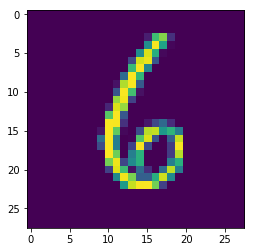

In [13]:
# Chose an image to feed
index = 140
digit_image = mnist.test.images[index]
plt.imshow(np.reshape(mnist.test.images[index], [28,28]))

In [14]:
prediction = tf.argmax(tf.nn.softmax(y), axis=1)
sess.run(prediction, feed_dict={x: digit_image[None]}) # Add None to have a array of shape [1, 784]

array([6])

#### If you want to build a bigger model, and achive more than 99% accuracy you can go further on the Notebook
___

In [15]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, 784], name='input')
y_ = tf.placeholder(tf.float32, [None, 10], name='labels')

### [Multilayer Convolutional Network](https://www.tensorflow.org/get_started/mnist/pros#build_a_multilayer_convolutional_network)

To create this model, we're going to need to create a lot of weights and biases. One should generally initialize weights with a small amount of noise for symmetry breaking, and to prevent 0 gradients. Since we're using [ReLU]( https://en.wikipedia.org/wiki/Rectifier_(neural_networks) neurons, it is also good practice to initialize them with a slightly positive initial bias to avoid "dead neurons". 

The two first functions will create and initialize the weights `weight_variable` and biases `bias_variable`. `conv2d` and `max_pool_2x2` perform 2D convolution and max-pooling 2x2 (which halves the size of the image each time)

In [16]:
def weight_variable(shape, name=None):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name=None):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

In [17]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

#### First  layer : convolution + max-pooling
The first layer will consist of a convolution, followed by max pooling. The convolution will compute 32 features for each 5x5 patch. Its weight tensor will have a shape of `[5, 5, 1, 32]`. The first two dimensions are the patch size (`[5,5]`), the next is the number of input channels ([`1`]), and the last is the number of output channels ([`32`]). We will also have a bias vector with a component for each output channel (of size `[32]` to be able to add it to the weighted input).

Before applying the convolution, we need to reshape the flatten 784 vector to get a 28x28 image in order to apply 2D convolution and extend the 2D image to a 4D tensor (final dimension corresponding to the number of color channels).

Then we convolve the image with the weights `W1`, add the biases `b1`, apply the ReLU activation and max-pool the result. This results in a tensor of shape `[?, 14, 14, 32]`

In [25]:
x_image = tf.reshape(x, [-1, 28, 28, 1])

with tf.name_scope('layer-1'):
    W_conv1 = weight_variable([5, 5, 1, 32])
    b_conv1 = bias_variable([32])

    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

#### Second layer : convolution + max-pooling
Repeat the layer. This time the convolution computes 64 features. The 2x2 max-pooling will reduce the size of the output to `[?, 7, 7, 64]`

In [19]:
with tf.name_scope('layer-2'):
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

#### Third layer : densely connected
We add a fully-connected layer with 1024 neurons to allow processing on the entire image. We reshape the tensor from the pooling layer into a batch of vectors, multiply by a weight matrix, add a bias, and apply a ReLU.

In [20]:
with tf.name_scope('layer-3'):
    W_fc1 = weight_variable([7 * 7 * 64, 1024])
    b_fc1 = bias_variable([1024])

    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

#### Last layer : readout
Last layer with 10 clasees output to apply the softmax function.

In [26]:
with tf.name_scope('layer-readout'):
    W_fc2 = weight_variable([1024, 10])
    b_fc2 = bias_variable([10])

    y_conv = tf.matmul(h_fc1, W_fc2) + b_fc2

_____
### Training the model and evaluating the perfomance while training

For the training, the loss function is the same as the simple model, but the optimizer algorithm is a more sophisticated one (ADAM). The accuracy computation doesn't change.

In [22]:
with tf.name_scope('loss'):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

This time when running the graph, we will use a `tf.Session` rather than `tf.InteractiveSession`. This better separates the process of creating the graph (model specification) and the process of evaluating the graph (model fitting). The tf.Session is created within a `with-block` so that it is automatically destroyed once the block is exited.

Also, this time we'll add logging to every 100th iteration in the training process

__Be aware that 20 000 training iterations may take a while (possibly up to half an hour), depending on your processor.__

The final accuracy should be above 99%

In [23]:
training_steps = 2000  # ideally 20'000
batch_size = 50
evaluation_interval = 100

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(training_steps):
        batch = mnist.train.next_batch(batch_size)
        if i % evaluation_interval == 0:
            train_accuracy = accuracy.eval(feed_dict={x: batch[0], y_: batch[1]})
            print('step %d, training accuracy %g' % (i, train_accuracy))
        train_step.run(feed_dict={x: batch[0], y_: batch[1]})

    print('test accuracy %g' % accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

step 0, training accuracy 0.1
step 100, training accuracy 0.9
step 200, training accuracy 0.9
step 300, training accuracy 0.98
step 400, training accuracy 0.94
step 500, training accuracy 0.98
step 600, training accuracy 0.96
step 700, training accuracy 0.98
step 800, training accuracy 0.98
step 900, training accuracy 0.98
step 1000, training accuracy 0.94
step 1100, training accuracy 1
step 1200, training accuracy 1
step 1300, training accuracy 0.98
step 1400, training accuracy 0.98
step 1500, training accuracy 1
step 1600, training accuracy 0.96
step 1700, training accuracy 0.88
step 1800, training accuracy 1
step 1900, training accuracy 1
test accuracy 0.9812


### Tensorboard
To visualize the graph of your model you can run from a terminal `tensorboard --logdir logdir`

¨¨Then go to `localhost:6006`

__Warning__ execute each cell only once to have a nice graph

In [27]:
writer = tf.summary.FileWriter(logdir='logdir', graph=tf.get_default_graph())